# Multi-Sequence Polyline Evaluation

Evaluates generated polylines for selected dataset sequences (`file_idx`).

- **Data Structure**:
  - Root: `data/issue/converted_bin/{file_idx}/`
  - GT: `{file_idx}/points_seq_1.bin` (Header + 6 floats/point)
  - Trajectory: `{file_idx}/vehicle_trajectory.bin`
  - Merged Polylines: `{file_idx}/merged_polylines/frame_*.bin` (Complex Structure)
  
- **Metric**: Chamfer Distance (Precision/Recall) within ROI.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import struct
import os
import glob

# %matplotlib inline

## 1. Configuration & Loaders

In [ ]:
# --- CONFIGURATION ---
WS_PATH = os.path.abspath("../") 
if not os.path.exists(os.path.join(WS_PATH, "data")): 
    WS_PATH = "/Users/sukhosong/RideFlux/toy_map_viewer"

BASE_DATA_DIR = os.path.join(WS_PATH, "data/issue/converted_bin")
GT_FILENAME = "points_seq_1.bin"

# Select Targets: List of strings ['0', '1'] or None for 'All'
TARGET_SEQUENCES = ['1'] 

# Parameters
ROI_RADIUS = 30.0    
MATCH_DIST_TH = 0.5 

# --- HELPERS ---
def read_points_bin(filename):
    """Reads Point Cloud (Header+Stride=24) or (Stride=16)"""
    if not os.path.exists(filename): return np.array([])
    with open(filename, 'rb') as f:
        header = f.read(4)
        if len(header) < 4: return np.array([])
        
        content = f.read()
        # Try Stride 24 (6 floats)
        if len(content) % 24 == 0:
             num_points = len(content) // 24
             data = struct.unpack(f'{num_points*6}f', content)
             points = np.array(data).reshape(-1, 6)
        # Try Stride 16 (4 floats)
        elif len(content) % 16 == 0:
             num_points = len(content) // 16
             data = struct.unpack(f'{num_points*4}f', content)
             points = np.array(data).reshape(-1, 4)
        else:
             return np.array([])
    return points[:, :3]

def read_custom_polylines_bin(filename):
    """Reads Complex Polyline Binary Format"""
    points_list = []
    if not os.path.exists(filename): return np.array([])
    
    with open(filename, 'rb') as f:
        # 1. Total Polyline Num
        data = f.read(4)
        if len(data) < 4: return np.array([])
        total_poly_num = struct.unpack('I', data)[0]
        
        for _ in range(total_poly_num):
            # 2. ID(4), Layer(4), Size(4) => 12 bytes
            meta = f.read(12)
            if len(meta) < 12: break
            pid, layer, p_size = struct.unpack('iiI', meta)
            
            # 3. Points (p_size * 12 bytes => x,y,z)
            raw_pts = f.read(p_size * 12)
            if len(raw_pts) < p_size * 12: break
            
            pts = struct.unpack(f'{p_size*3}f', raw_pts)
            pts = np.array(pts).reshape(-1, 3)
            points_list.append(pts)
            
    if not points_list: return np.array([])
    return np.vstack(points_list) # Flatten to point cloud

Processing 1 sequences: ['0']

=== Processing Sequence: 0 ===
  Evaluating 300 frames...
  -> Mean Prec: 0.2083, Mean Rec: 0.0261, Mean F1: 0.0053


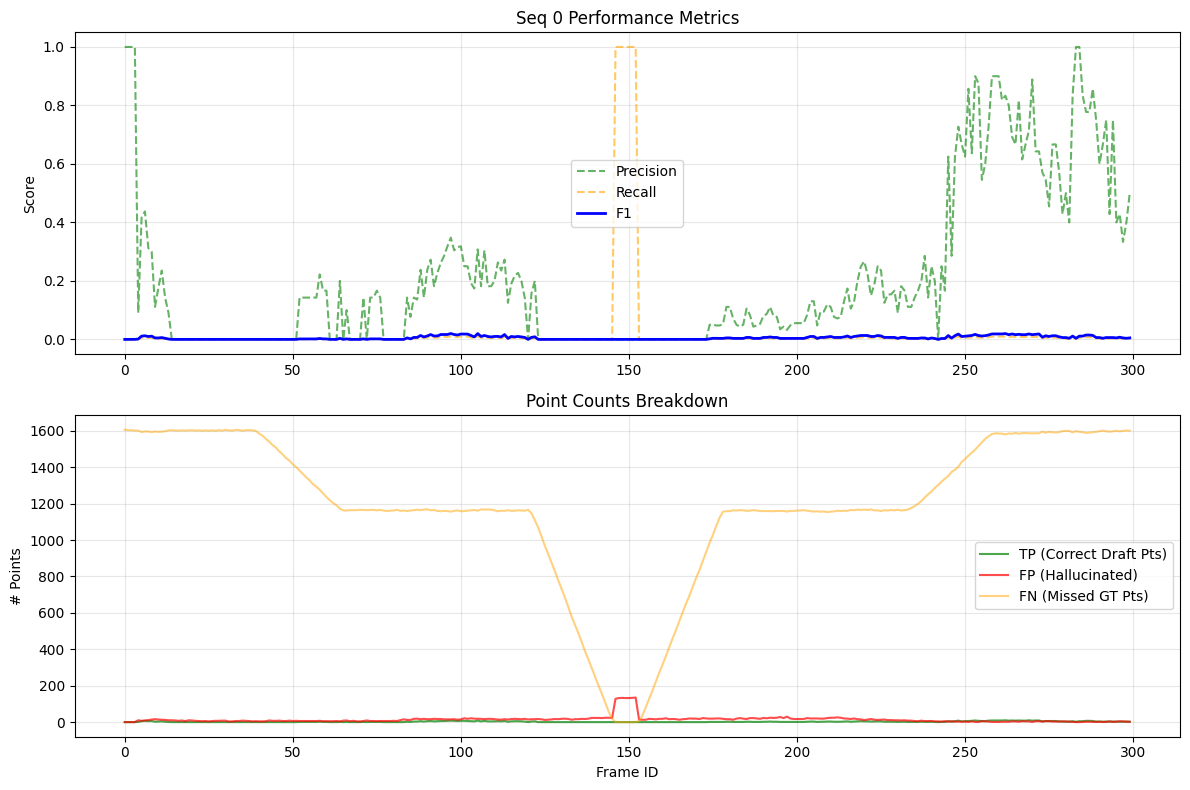

In [44]:
# Determine Subdirectories
if TARGET_SEQUENCES is None:
    seq_dirs = sorted(glob.glob(os.path.join(BASE_DATA_DIR, "*")))
    seq_dirs = [d for d in seq_dirs if os.path.isdir(d)]
else:
    # Verify specified targets exist
    seq_dirs = []
    for t in TARGET_SEQUENCES:
        p = os.path.join(BASE_DATA_DIR, t)
        if os.path.isdir(p):
            seq_dirs.append(p)
        else:
            print(f"[WARN] Target sequence '{t}' not found at {p}")

print(f"Processing {len(seq_dirs)} sequences: {[os.path.basename(d) for d in seq_dirs]}")

overall_stats = {}

for seq_dir in seq_dirs:
    seq_name = os.path.basename(seq_dir)
    print(f"\n=== Processing Sequence: {seq_name} ===")
    
    # 1. Load GT
    gt_file = os.path.join(seq_dir, GT_FILENAME)
    gt_points = read_points_bin(gt_file)
    
    if len(gt_points) == 0:
        print("GT missing/empty, skipping.")
        continue
    gt_tree = KDTree(gt_points[:, :2])
    
    # 2. Load Trajectory
    traj_file = os.path.join(seq_dir, "vehicle_trajectory.bin")
    traj_points = read_points_bin(traj_file)
    if len(traj_points) == 0:
        print("Trajectory missing, skipping.")
        continue
        
    draft_dir = os.path.join(seq_dir, "merged_polylines")
    seq_results = {
        'frames': [], 'precision': [], 'recall': [], 'f1': [],
        'TP': [], 'FP': [], 'FN_G': [] # FN_G: Mean False Negative from GT perspective
    }
    
    num_frames = traj_points.shape[0]
    print(f"  Evaluating {num_frames} frames...")
    
    for i in range(num_frames):
        ego_pos = traj_points[i, :2]
        
        # Load Draft with CUSTOM PARSER
        draft_path = os.path.join(draft_dir, f"{i}.bin")
        if not os.path.exists(draft_path): draft_path = os.path.join(draft_dir, f"frame_{i}.bin")
        if not os.path.exists(draft_path): draft_path = os.path.join(draft_dir, f"{i:04d}.bin")
        
        # Use new loader
        draft_points = read_custom_polylines_bin(draft_path)
        
        # ROI Filter GT
        gt_indices = gt_tree.query_ball_point(ego_pos, ROI_RADIUS)
        
        precision, recall, f1 = 0.0, 0.0, 0.0
        tp_count, fp_count, fn_count = 0, 0, 0
        
        if len(gt_indices) == 0:
            # No GT in this area
            if len(draft_points) > 0: 
                # Only False Positives
                precision=0.0; recall=1.0; f1=0.0
                fp_count = len(draft_points)
            else:
                # Perfect (Empty matches Empty)
                precision=1.0; recall=1.0; f1=1.0
        else:
            gt_local = gt_points[gt_indices]
            fn_count = len(gt_local)
            
            if len(draft_points) == 0:
                # Missed everything
                precision=1.0; recall=0.0; f1=0.0
            else:
                draft_tree_tmp = KDTree(draft_points[:, :2])
                valid_draft_idx = draft_tree_tmp.query_ball_point(ego_pos, ROI_RADIUS)
                
                if len(valid_draft_idx) == 0:
                    precision=1.0; recall=0.0; f1=0.0
                else:
                    draft_local = draft_points[valid_draft_idx]
                    
                    # --- Precision Side (Draft -> GT) ---
                    # Each Draft Point is TP if dist < TH, else FP
                    draft_tree_local = KDTree(draft_local[:, :2])
                    gt_tree_local = KDTree(gt_local[:, :2])
                    
                    dists_d2g, _ = gt_tree_local.query(draft_local[:, :2])
                    is_tp_d = dists_d2g < MATCH_DIST_TH
                    
                    tp_count_p = np.sum(is_tp_d)          # TP (Precision view)
                    fp_count = len(draft_local) - tp_count_p  # FP
                    prec = tp_count_p / len(draft_local)
                    
                    # --- Recall Side (GT -> Draft) ---
                    # Each GT Point is Maintained or Missed
                    dists_g2d, _ = draft_tree_local.query(gt_local[:, :2])
                    is_tp_g = dists_g2d < MATCH_DIST_TH
                    
                    tp_count_r = np.sum(is_tp_g)          # TP (Recall view, Many-to-One)
                    fn_count = len(gt_local) - tp_count_r     # FN
                    rec = tp_count_r / len(gt_local)
                    
                    # Final Metrics
                    precision = prec
                    recall = rec
                    f1 = 2*(prec*rec)/(prec+rec) if (prec+rec)>0 else 0.0
                    tp_count = tp_count_p # Use Precision's TP count for display
        
        seq_results['frames'].append(i)
        seq_results['precision'].append(precision)
        seq_results['recall'].append(recall)
        seq_results['f1'].append(f1)
        seq_results['TP'].append(tp_count)
        seq_results['FP'].append(fp_count)
        seq_results['FN_G'].append(fn_count)
        
    if len(seq_results['f1']) > 0:
        mean_prec = np.mean(seq_results['precision'])
        mean_rec = np.mean(seq_results['recall'])
        mean_f1 = np.mean(seq_results['f1'])
        overall_stats[seq_name] = {'precision': mean_prec, 'recall': mean_rec, 'f1': mean_f1}
        print(f"  -> Mean Prec: {mean_prec:.4f}, Mean Rec: {mean_rec:.4f}, Mean F1: {mean_f1:.4f}")
        
        # Plot 1: Metrics
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 1, 1)
        plt.plot(seq_results['precision'], label='Precision', color='green', alpha=0.6, linestyle='--')
        plt.plot(seq_results['recall'], label='Recall', color='orange', alpha=0.6, linestyle='--')
        plt.plot(seq_results['f1'], label='F1', color='blue', linewidth=2)
        plt.title(f"Seq {seq_name} Performance Metrics")
        plt.ylabel("Score")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(-0.05, 1.05)
        
        # Plot 2: Counts (TP, FP, FN)
        plt.subplot(2, 1, 2)
        plt.plot(seq_results['TP'], label='TP (Correct Draft Pts)', color='green', alpha=0.7)
        plt.plot(seq_results['FP'], label='FP (Hallucinated)', color='red', alpha=0.7)
        plt.plot(seq_results['FN_G'], label='FN (Missed GT Pts)', color='orange', alpha=0.5)
        plt.title("Point Counts Breakdown")
        plt.ylabel("# Points")
        plt.xlabel("Frame ID")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("  -> No frames evaluated")